In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


[[-0.7105200622055914, -0.0836588089097281, -0.9928073965159707, 0.19871094846626947], [-0.12142951867491214, 0.017725727828397764, -0.016275531090425677, 0.022669489733093018], [-0.013418541627104874, 0.1230861287523326, 0.3211926237641163, 0.07382115887443108], [-0.26389798533306297, -0.11745365448910339, -0.45139687248752225, -0.06169754898054247], [-0.7277488070107632, 0.3384454388169791, 0.27601972114579176, 0.6245319863831227], [1.1634372573723173, 0.0541711495316457, 0.8592816108353349, -0.29287652120373275], [0.6008524750803639, -0.20426002254593012, 0.07207735197188558, -0.37392202296013854], [0.07272518239875381, -0.12805595898459377, -0.06809150762320981, -0.1912374903125027]]
[[ 3.47365650e-08  1.10203889e-07 -2.55078632e-04]
 [-9.84151569e-08  2.78700145e-07 -3.54487652e-04]
 [ 1.12530977e-04 -6.44904172e-04  9.99999690e-01]]
[[-4.75502917e-08  1.34307696e-07 -1.54010674e-04]
 [-1.50632863e-07 -3.80740533e-07  8.80566916e-04]
 [ 3.48343758e-04  4.83902578e-04 -1.36320207e+

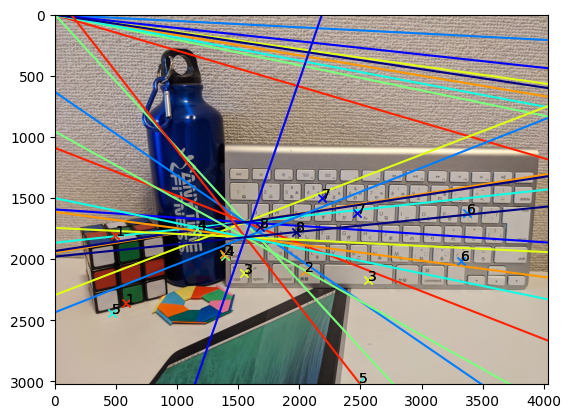

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import os


# low depth variance image same plane
uvMat = [[1855,1352, 1680, 1305], [2100, 2116, 1914, 2084], [2482, 1994, 2310, 1984], [3070, 1336, 2959, 1337], [3450, 1911, 3369, 1966], [1356, 1885, 1173, 1809],\
    [3415,2125, 3320, 2190], [3848, 1308, 3846, 1342]]

# low depth variance different plane
uvMat1 = [[1855,1352, 1680, 1305], [1251,2640, 960, 2518], [525, 2436, 323, 2273], [745, 1840, 611,1734], [1578, 2890, 1174, 2783], [1356, 1885, 1173, 1809],\
    [3415,2125, 3320, 2190], [3848, 1308, 3846, 1342]]

# high depth variance image same plane
uvMat2 = [[580, 2362, 492, 1803], [2050, 2097, 1381, 1956], [2558, 2174, 1544, 2115], [1395, 1970, 1166, 1752], [2490, 3003, 466, 2440], [3368, 1622, 3320, 2011],\
    [2183, 1500, 2471,1621], [1972,1775, 1674, 1736]]

# high depth variance image different plane
uvMat3 = [[580, 2362, 492, 1803],[3316,1276, 3242, 1565], [1007,788, 1606,885] , [1900, 1144, 2330, 1250], [984, 1369, 1574, 1335], [3368, 1622, 3320, 2011],\
    [2192, 1288, 2469, 1420], [2050, 2097, 1381, 1956]]
uvMat = uvMat2
# %%
# def main(uvMat):
#     close1, close2, far1, far2 = load_imgs()
#     # norm_points, T1, T2 = normalize(uvMat)
    
#     f_hat = calc_F(norm_points)

#     f_mat = restore(f_hat, T1, T2)
#     plot1(close1, f_mat, uvMat) 

#     plot2(close2, f_mat, uvMat)
# main(uvMat)


def load_imgs():
    close1  = plt.imread("same1.jpg")
    close2 = plt.imread('same2.jpg')
    far1  = plt.imread("extreme1.jpg")
    far2 = plt.imread('extreme2.jpg')
    return close1, close2, far1, far2
close1, close2, far1, far2 = load_imgs()


from functools import reduce
def normalize(points):
    # T1 acts on x,y to give x_hat
    # T2 acts on x'y' to give x'_hat 
    n = len(points)
    img1_pts, img2_pts = [], []
    for a,b,c,d in points:
        img2_pts.append([a,b])
        img1_pts.append([c,d])
    sum1 = reduce(lambda x, y:  (x[0]+y[0], x[1]+y[1]), img1_pts)
    sum2 = reduce(lambda x, y:  (x[0]+y[0], x[1]+y[1]), img2_pts)
    
    mean1 = [val/n for val in sum1]
    mean2 = [val/n for val in sum2]

    s1 = (n*2)**0.5/(sum([((x-mean1[0])**2 + (y-mean1[1])**2)**0.5 for x,y in img1_pts]))
    s2 = (2*n)**0.5/(sum([((x-mean2[0])**2 + (y-mean2[1])**2)**0.5 for x,y in img2_pts]))

    T1 = np.array([[s1, 0, -mean1[0]*s1], [0, s1, -mean1[1]*s1], [0, 0, 1]])
    T2 = np.array([[s2, 0, -mean2[0]*s2], [0, s2, -mean2[1]*s2], [0, 0, 1]])

    points = [[T1 @ [c, d, 1], T2 @ [a,b,1]] for a,b,c,d in points]
    points = [[l[0], l[1], r[0], r[1]] for l,r in points]
    return points, T1, T2

norm_points, T1, T2 = normalize(uvMat)
print(norm_points)

def calc_F(uvMat):
    A = np.zeros((len(uvMat),9))
    # img1 x' y' x y im2
    for i in range(len(uvMat)):
        A[i][0] = uvMat[i][0]*uvMat[i][2]
        A[i][1] = uvMat[i][1]*uvMat[i][2]
        A[i][2] = uvMat[i][2]
        A[i][3] = uvMat[i][0]*uvMat[i][3]
        A[i][4] = uvMat[i][1]*uvMat[i][3]
        A[i][5] = uvMat[i][3] 
        A[i][6] = uvMat[i][0]
        A[i][7] = uvMat[i][1]
        A[i][8] = 1.0  
    
    _,_,v = np.linalg.svd(A)
    # print("v", v)
    f_vec = v.transpose()[:,8]
    # print("f_vec = ", f_vec)
    f_hat = np.reshape(f_vec, (3,3))
    # print("Fmat = ", f_hat)

    # Enforce rank(F) = 2 
    s,v,d = np.linalg.svd(f_hat)
    f_hat = s @ np.diag([*v[:2], 0]) @ d

    return f_hat


# Regular version
f_hat = calc_F(uvMat)
print(f_hat)


# normalized version
f_hat = calc_F(norm_points)


# Restore to the original coordinates
def restore(f_hat, T1, T2):
    f_mat = T2.transpose() @ f_hat @ T1
    return f_mat 

f_mat = restore(f_hat, T1, T2)
print(f_mat)


cmap = plt.get_cmap("jet_r")
# plot on img1
def plot1(img, f_mat, points):
    w = img.shape[1]
    num = 1
    for x, y, *pt in points:
        color = cmap(num/len(points))
        a,b,c = np.array([*pt, 1]).transpose() @ f_mat
        p1 = (0,-c/b)
        p2 = (w, -(a*w + c)/b)
        plt.plot(*zip(p1,p2), color=color)
        plt.plot(x, y, "x",color=color)
        plt.text(x,y,f"{num}")
        num+=1
    plt.imshow(img)


# plot on img 2 
# epipolar lines based on  x'y' and points x,y
def plot2(img, f_mat, points):
    w = img.shape[1]
    num = 1
    for *pt, x,y in points:
        color = cmap(num/len(points))
        a,b,c = f_mat @ [*pt, 1]
        p1 = (0,-c/b)
        p2 = (w, -(a*w + c)/b)
        plt.plot(*zip(p1,p2), color=color)
        plt.plot(x,y, "x", color=color)
        plt.text(x,y,f"{num}")
        num+=1
    plt.imshow(img)



# Plot the epipolar lines
plot1(close1, f_hat, uvMat) 


plot2(close2, f_hat, uvMat2)


# Epipoles
def check_epipoles(f_mat):
    f_mat = f_hat
    f_mat_2 = f_mat.transpose() @ f_mat
    w3, v3 = np.linalg.eig(f_mat_2)
    smallest = np.argmin(w3)
    f_vec = v3[:,smallest]
    e1vec = f_vec/f_vec[2]
    p1 = uvMat[0]
    point1 = p1[2:] #[3641, 2373]#[826, 649]
    lp = f_hat @ [*point1,1]
    print("e1: ", e1vec)
    print(f_hat @ e1vec @ [*point1,1])

    f_T_f_mat = f_mat @ f_mat.transpose()
    w4 , v4 = np.linalg.eig(f_T_f_mat)
    smallest = np.argmin(w4)
    f_vec = v4[:,smallest]
    e2vec = f_vec/f_vec[2]
    print("e2: ", e2vec)
    point2 = p1[:2]
    print(e2vec @ f_hat  @ [*point2,1]) 

check_epipoles(f_hat)


close1, close2, far1, far2 = load_imgs()
norm_points, T1, T2 = normalize(uvMat)

f_hat = calc_F(norm_points)

f_mat = restore(f_hat, T1, T2)
plot1(close1, f_mat, uvMat) 

plot2(close2, f_mat, uvMat)

##### credit :

In [ ]:
## resources from https://github.com/Smelton01/8-point-algorithm/